In [1]:
import cv2
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
base_dir = "Images"

In [3]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Root directory contains all subdirectories (e.g., 'good', 'crack', etc.)
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Iterate through subdirectories
        for subdir in os.listdir(root_dir):
            subdir_path = os.path.join(root_dir, subdir)
            if os.path.isdir(subdir_path):
                # If the subdirectory is 'good', label as 0 (non-anomalous), else label as 1
                label = 0 if subdir == 'good' else 1
                for image_name in os.listdir(subdir_path):
                    image_path = os.path.join(subdir_path, image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Open image and convert to RGB
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [34]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # Downsample by a factor of 2
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Downsample by another factor of 2
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Downsample further
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.1),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),  # To normalize output to [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [22]:
# Prepare the data
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert to grayscale
    transforms.Resize((512, 512)),  # Resize to a fixed size
    transforms.ToTensor()
])

In [6]:
def calculate_reconstruction_errors(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    reconstruction_errors = []

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            reconstructed = model(images)

            # Compute the reconstruction error (e.g., Mean Squared Error)
            error = (images - reconstructed).pow(2).mean(dim=(1, 2, 3))  # Mean over height, width, channels
            reconstruction_errors.extend(error.cpu().numpy())  # Move to CPU and add to the list
    
    return reconstruction_errors

In [50]:
def train_autoencoder(autoencoder, dataloader, item, num_epochs, device, optimizer, scheduler, save_path="."):
    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)
    
    # Move the model to the specified device
    autoencoder.to(device)
    
    best_loss = float('inf')
    
    # Training loop
    for epoch in range(num_epochs):
        autoencoder.train()
        running_loss = 0.0
        
        for images, _ in dataloader:
            images = images.to(device)  # Move data to the same device as the model
            
            # Forward pass
            reconstructed = autoencoder(images)
            loss = criterion(reconstructed, images)  # Compare reconstructed and original images
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Print epoch summary
        avg_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.6f}")

        # Step the learning rate scheduler
        scheduler.step(avg_loss)

        # Visualize some sample images and their reconstruction errors
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            autoencoder.eval()  # Set model to eval mode for visualization
            with torch.no_grad():
                sample_images, _ = next(iter(dataloader))  # Take a batch from the dataloader
                sample_images = sample_images.to(device)
                reconstructed = autoencoder(sample_images)

                # Plot original and reconstructed images
                fig, ax = plt.subplots(1, 2, figsize=(8, 6))
                ax[0].imshow(sample_images[0].cpu().squeeze(), cmap='gray')
                ax[0].set_title('Original Image')
                ax[0].axis('off')
                ax[1].imshow(reconstructed[0].cpu().squeeze(), cmap='gray')
                ax[1].set_title('Reconstructed Image')
                ax[1].axis('off')
                plt.show()

            # Calculate reconstruction errors for visualization after each epoch
            errors = calculate_reconstruction_errors(autoencoder, dataloader, device)
            
            # Plot histogram of reconstruction errors
            plt.figure(figsize=(8, 8))
            plt.hist(errors, bins=50, color='blue', alpha=0.7)
            plt.title(f'Distribution of Reconstruction Errors (Epoch {epoch + 1})')
            plt.xlabel('Reconstruction Error (MSE)')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()

        # Save the model if validation loss has improved
        if avg_loss < best_loss:
            best_loss = avg_loss
            model_filename = f"{item}_autoencoder.pth"
            model_path = os.path.join(save_path, model_filename)
            torch.save(autoencoder.state_dict(), model_path)
            print(f"Model saved with loss: {avg_loss:.4f}")        
    
    return model_path, errors

In [57]:
def test_autoencoder(model, best_model_path, test_loader, device, threshold):
    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    print("Loaded best model weights from training.")
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    false_positives = 0  # Counter for false positives
    false_negatives = 0  # Counter for false negatives
    true_positives = 0   # Counter for true positives
    true_negatives = 0   # Counter for true negatives
    total_good_images = 0  # Count of actual "good" images

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)  # These are the class labels (0 for "good", 1 for everything else)
            
            # Get the model's reconstruction of the images
            reconstructed = model(images)

            # Calculate the reconstruction error (difference between input and output)
            reconstruction_error = torch.mean((reconstructed - images) ** 2, dim=[1, 2, 3])

            # Identify anomalies based on reconstruction error exceeding the threshold
            predicted_anomalies = reconstruction_error > threshold

            # Track false positives/negatives, true positives/negatives
            for i, is_anomalous in enumerate(predicted_anomalies):
                image_label = labels[i].item()
                if image_label == 0:  # If it's a "good" image
                    total_good_images += 1
                    if is_anomalous.item():  # If predicted as anomalous (false positive)
                        false_positives += 1
                    else:  # Predicted as non-anomalous (true negative)
                        true_negatives += 1
                else:  # If it's an anomalous image
                    if is_anomalous.item():  # If predicted as anomalous (true positive)
                        true_positives += 1
                    else:  # Predicted as non-anomalous (false negative)
                        false_negatives += 1

            # Flatten the tensors for comparison
            predicted_anomalies = predicted_anomalies.view(-1)  # Flatten the anomalies tensor
            labels = (labels != 0).view(-1)  # Flatten labels and treat "good" as non-anomalous

            # Count correct predictions (for anomaly detection, assuming "good" = non-anomalous, others = anomalous)
            correct += (predicted_anomalies == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    # False positive rate will be number of false positives divided by total number of "good" images in the test set
    false_positive_rate = false_positives / total_good_images if total_good_images > 0 else 0

    # Precision, Recall, F1 Score
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Print metrics
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"False Positive Rate: {false_positive_rate:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

Processing: capsule
Epoch [1/100], Loss: 0.037715


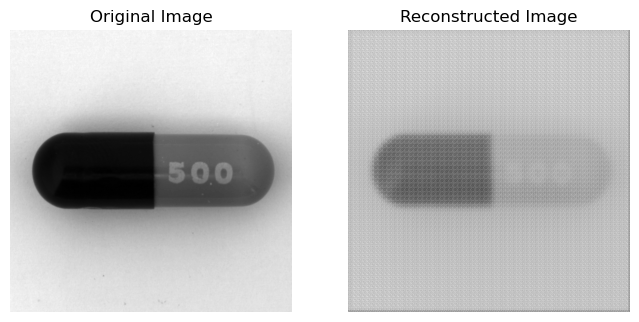

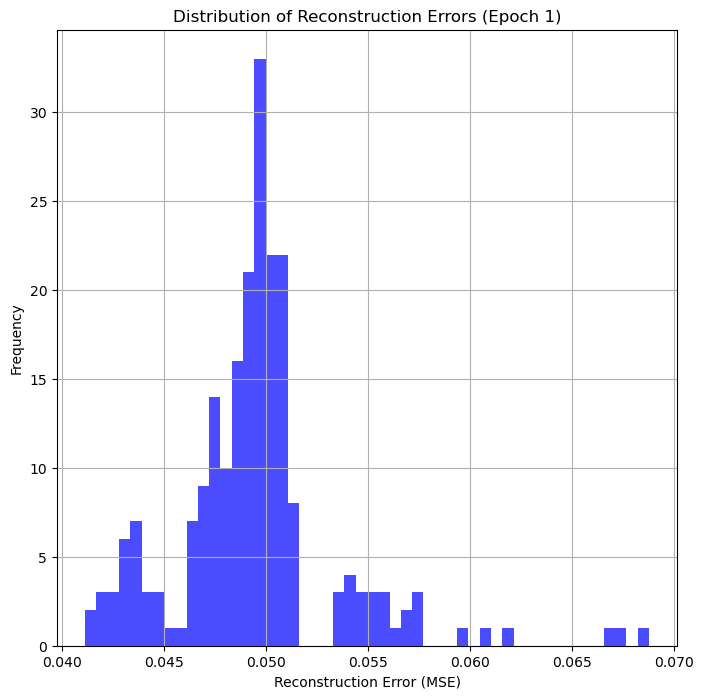

Model saved with loss: 0.0377
Epoch [2/100], Loss: 0.006331
Model saved with loss: 0.0063
Epoch [3/100], Loss: 0.003261
Model saved with loss: 0.0033
Epoch [4/100], Loss: 0.002202
Model saved with loss: 0.0022
Epoch [5/100], Loss: 0.001733
Model saved with loss: 0.0017
Epoch [6/100], Loss: 0.001438
Model saved with loss: 0.0014
Epoch [7/100], Loss: 0.001303
Model saved with loss: 0.0013
Epoch [8/100], Loss: 0.001151
Model saved with loss: 0.0012
Epoch [9/100], Loss: 0.001125
Model saved with loss: 0.0011
Epoch [10/100], Loss: 0.001063
Model saved with loss: 0.0011
Epoch [11/100], Loss: 0.000905


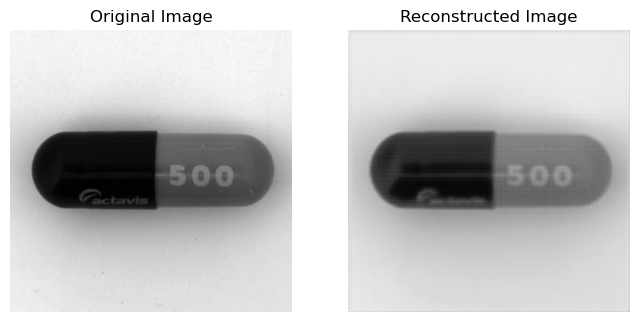

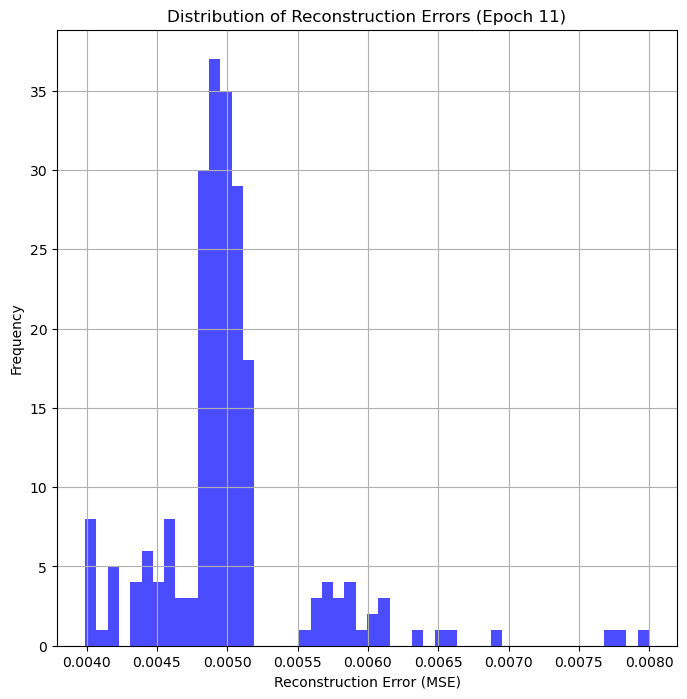

Model saved with loss: 0.0009
Epoch [12/100], Loss: 0.000927
Epoch [13/100], Loss: 0.001094
Epoch [14/100], Loss: 0.000833
Model saved with loss: 0.0008
Epoch [15/100], Loss: 0.000702
Model saved with loss: 0.0007
Epoch [16/100], Loss: 0.000606
Model saved with loss: 0.0006
Epoch [17/100], Loss: 0.000594
Model saved with loss: 0.0006
Epoch [18/100], Loss: 0.000534
Model saved with loss: 0.0005
Epoch [19/100], Loss: 0.000482
Model saved with loss: 0.0005
Epoch [20/100], Loss: 0.000477
Model saved with loss: 0.0005
Epoch [21/100], Loss: 0.000499


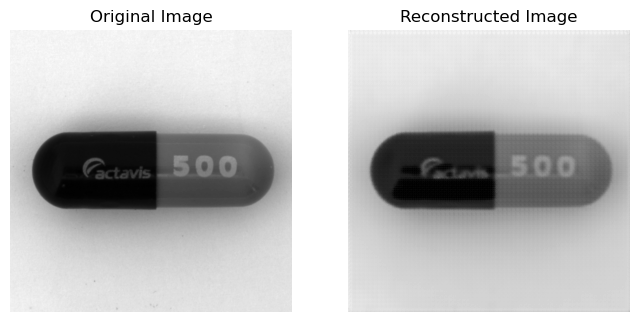

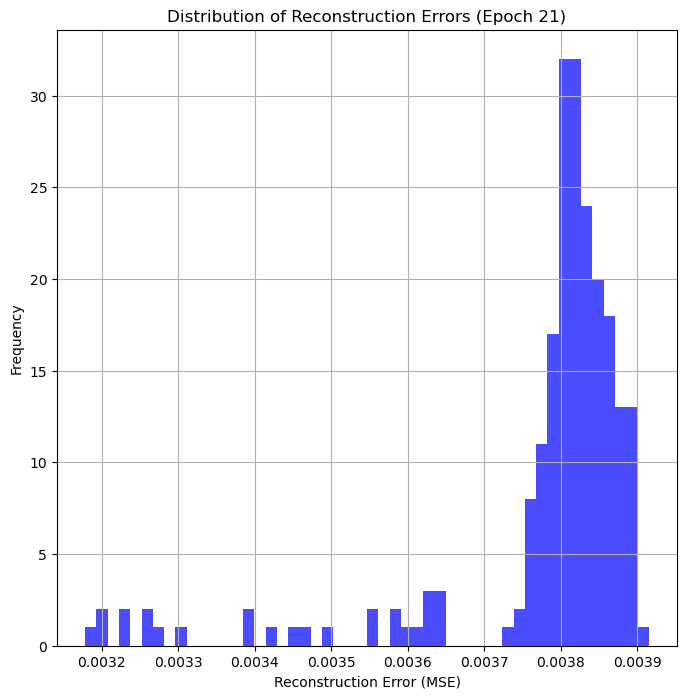

Epoch [22/100], Loss: 0.000536
Epoch [23/100], Loss: 0.000475
Model saved with loss: 0.0005
Epoch [24/100], Loss: 0.000435
Model saved with loss: 0.0004
Epoch [25/100], Loss: 0.000434
Model saved with loss: 0.0004
Epoch [26/100], Loss: 0.000369
Model saved with loss: 0.0004
Epoch [27/100], Loss: 0.000364
Model saved with loss: 0.0004
Epoch [28/100], Loss: 0.000342
Model saved with loss: 0.0003
Epoch [29/100], Loss: 0.000416
Epoch [30/100], Loss: 0.000356
Epoch [31/100], Loss: 0.000387


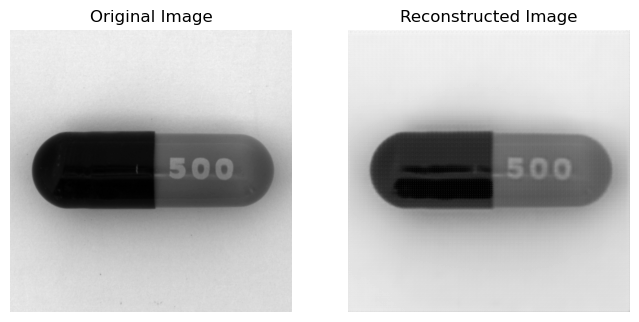

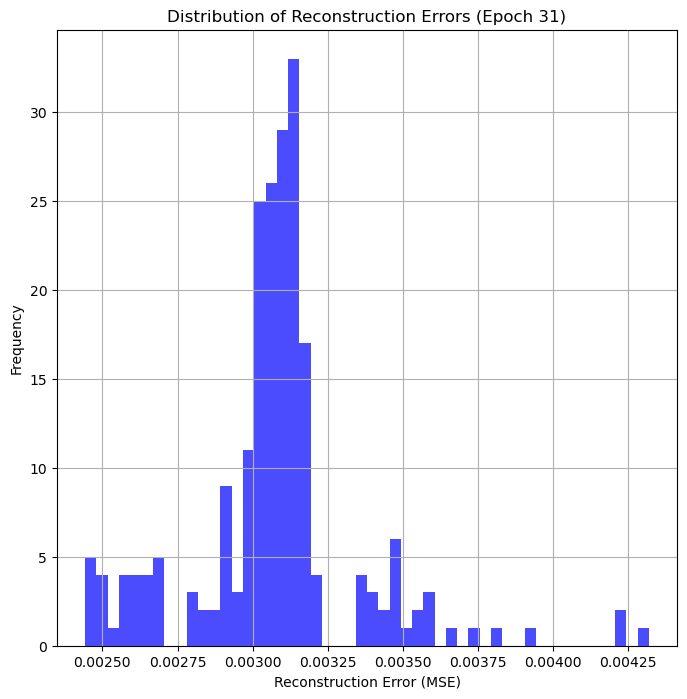

Epoch [32/100], Loss: 0.000330
Model saved with loss: 0.0003
Epoch [33/100], Loss: 0.000279
Model saved with loss: 0.0003
Epoch [34/100], Loss: 0.000307
Epoch [35/100], Loss: 0.000378
Epoch [36/100], Loss: 0.000344
Epoch [37/100], Loss: 0.000307
Epoch [38/100], Loss: 0.000248
Model saved with loss: 0.0002
Epoch [39/100], Loss: 0.000226
Model saved with loss: 0.0002
Epoch [40/100], Loss: 0.000718
Epoch [41/100], Loss: 0.000359


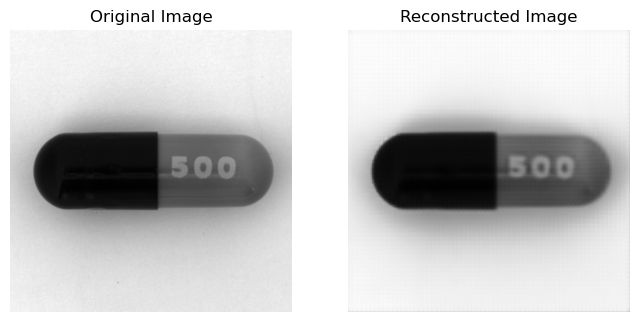

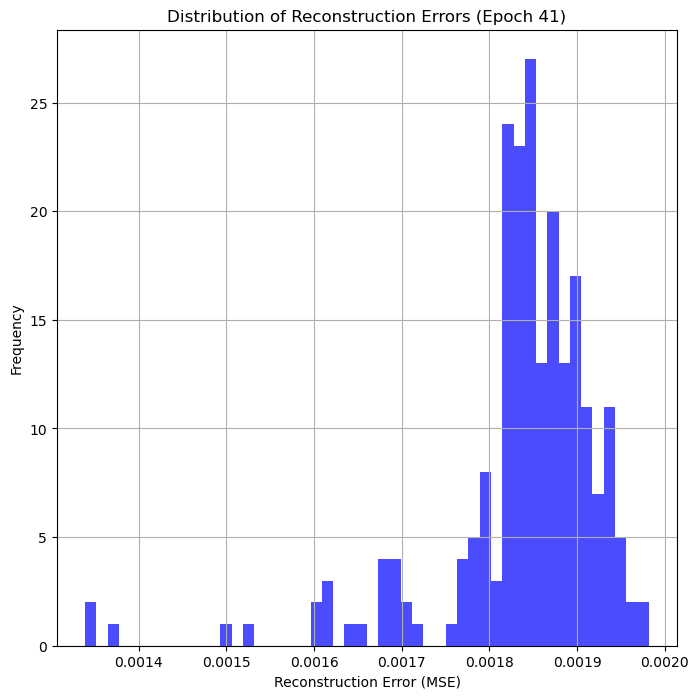

Epoch [42/100], Loss: 0.000257
Epoch [43/100], Loss: 0.000243
Epoch [44/100], Loss: 0.000222
Model saved with loss: 0.0002
Epoch [45/100], Loss: 0.000234
Epoch [46/100], Loss: 0.000280
Epoch [47/100], Loss: 0.000248
Epoch [48/100], Loss: 0.000215
Model saved with loss: 0.0002
Epoch [49/100], Loss: 0.000284
Epoch [50/100], Loss: 0.000234
Epoch [51/100], Loss: 0.000203


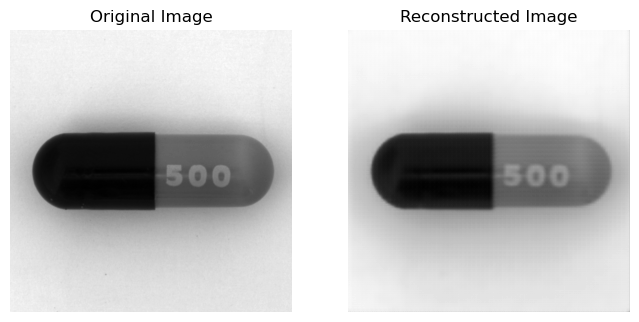

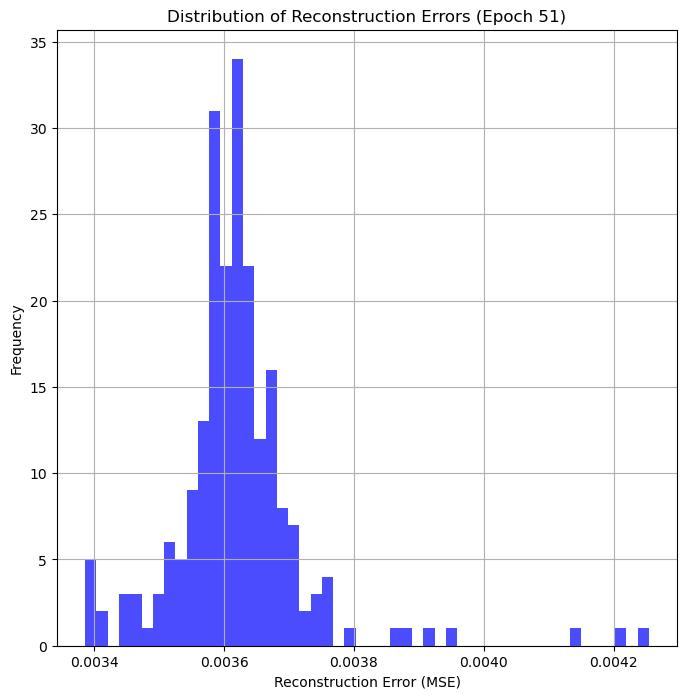

Model saved with loss: 0.0002
Epoch [52/100], Loss: 0.000203
Model saved with loss: 0.0002
Epoch [53/100], Loss: 0.000352
Epoch [54/100], Loss: 0.000333
Epoch [55/100], Loss: 0.000205
Epoch [56/100], Loss: 0.000243
Epoch [57/100], Loss: 0.000256
Epoch [58/100], Loss: 0.000267
Epoch [59/100], Loss: 0.000189
Model saved with loss: 0.0002
Epoch [60/100], Loss: 0.000170
Model saved with loss: 0.0002
Epoch [61/100], Loss: 0.000180


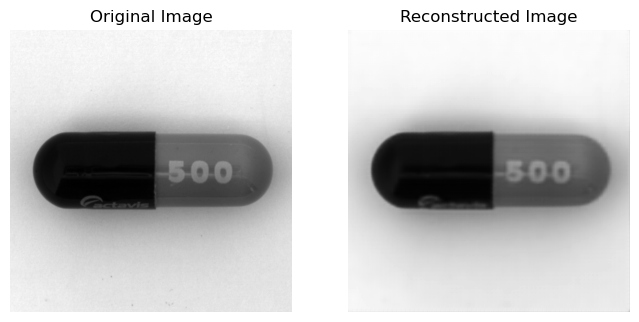

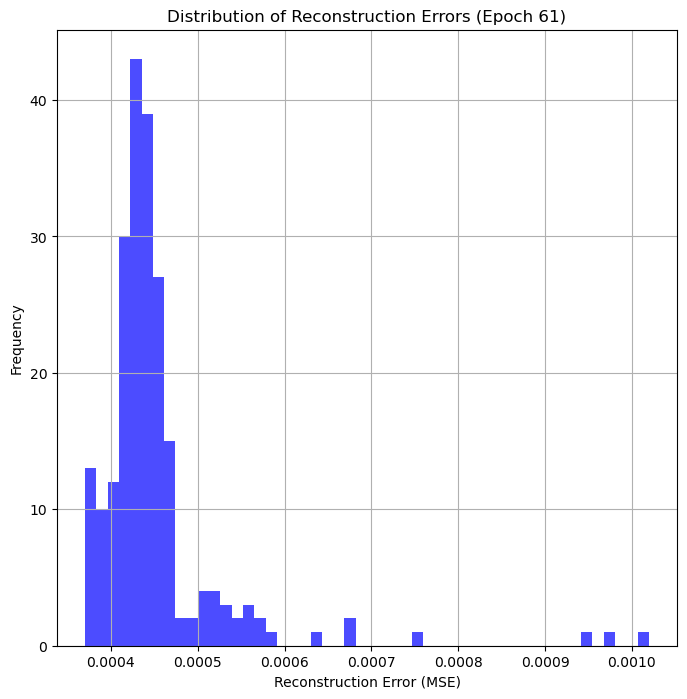

Epoch [62/100], Loss: 0.000164
Model saved with loss: 0.0002
Epoch [63/100], Loss: 0.000159
Model saved with loss: 0.0002
Epoch [64/100], Loss: 0.000161
Epoch [65/100], Loss: 0.000145
Model saved with loss: 0.0001
Epoch [66/100], Loss: 0.000163
Epoch [67/100], Loss: 0.000152
Epoch [68/100], Loss: 0.000146
Epoch [69/100], Loss: 0.000149
Epoch [70/100], Loss: 0.000143
Model saved with loss: 0.0001
Epoch [71/100], Loss: 0.000159


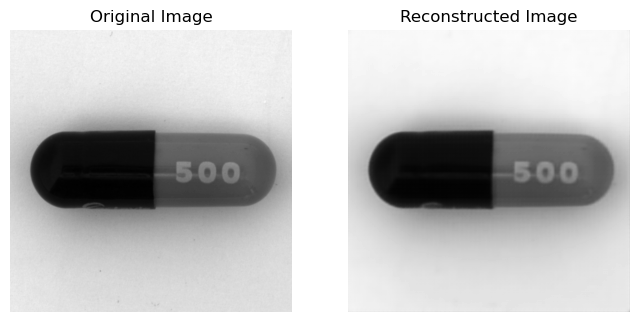

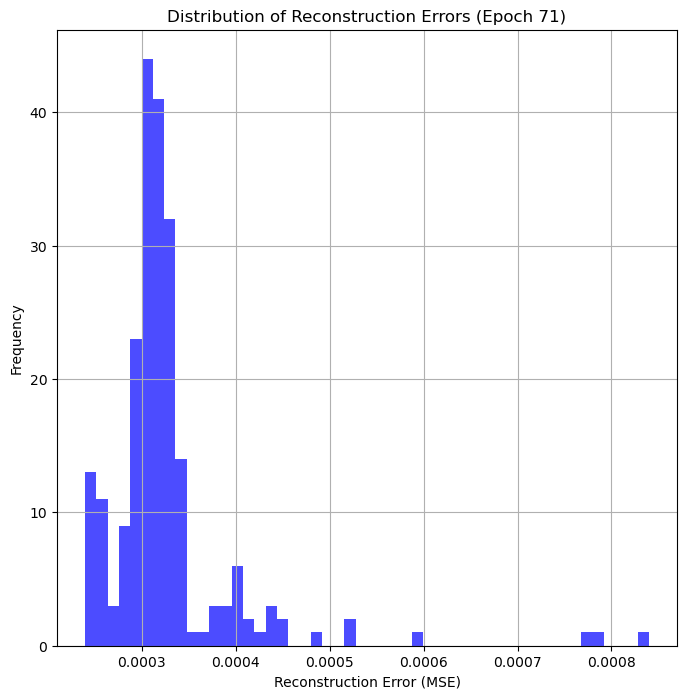

Epoch [72/100], Loss: 0.000145
Epoch [73/100], Loss: 0.000140
Model saved with loss: 0.0001
Epoch [74/100], Loss: 0.000145
Epoch [75/100], Loss: 0.000155
Epoch [76/100], Loss: 0.000149
Epoch [77/100], Loss: 0.000143
Epoch [78/100], Loss: 0.000147
Epoch [79/100], Loss: 0.000131
Model saved with loss: 0.0001
Epoch [80/100], Loss: 0.000142
Epoch [81/100], Loss: 0.000162


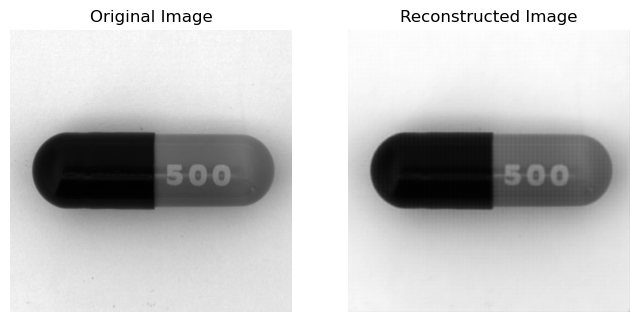

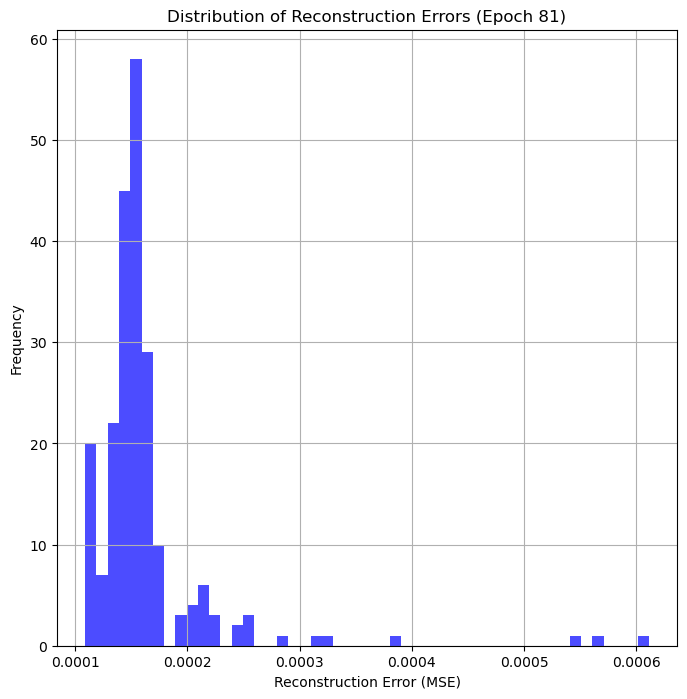

Epoch [82/100], Loss: 0.000144
Epoch [83/100], Loss: 0.000154
Epoch [84/100], Loss: 0.000138
Epoch [85/100], Loss: 0.000121
Model saved with loss: 0.0001
Epoch [86/100], Loss: 0.000142
Epoch [87/100], Loss: 0.000124
Epoch [88/100], Loss: 0.000155
Epoch [89/100], Loss: 0.000134
Epoch [90/100], Loss: 0.000155
Epoch [91/100], Loss: 0.000150


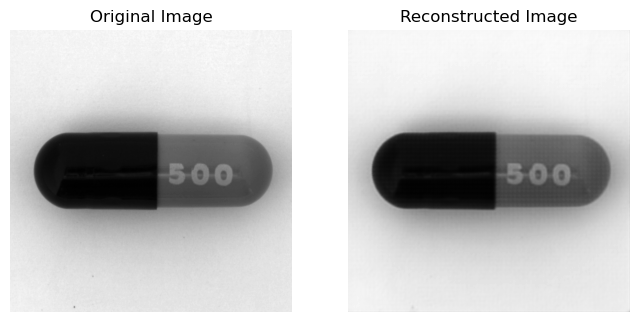

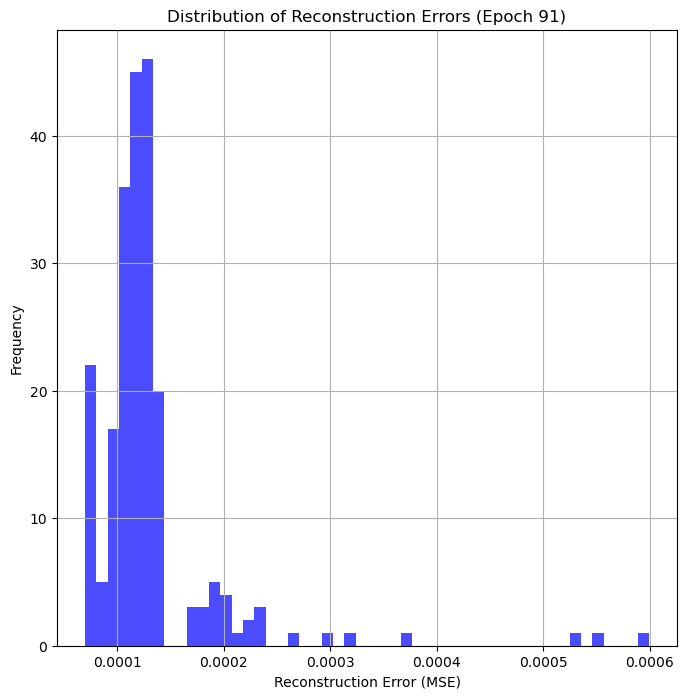

Epoch [92/100], Loss: 0.000124
Epoch [93/100], Loss: 0.000119
Model saved with loss: 0.0001
Epoch [94/100], Loss: 0.000115
Model saved with loss: 0.0001
Epoch [95/100], Loss: 0.000113
Model saved with loss: 0.0001
Epoch [96/100], Loss: 0.000109
Model saved with loss: 0.0001
Epoch [97/100], Loss: 0.000117
Epoch [98/100], Loss: 0.000114
Epoch [99/100], Loss: 0.000113
Epoch [100/100], Loss: 0.000111


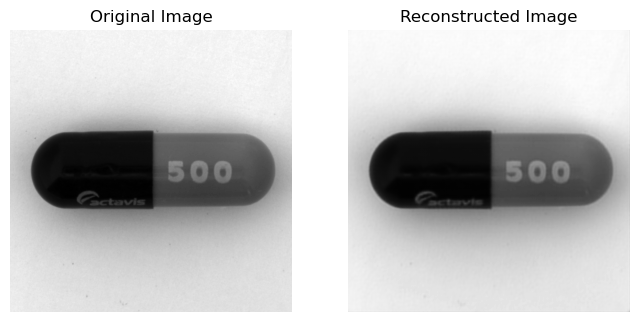

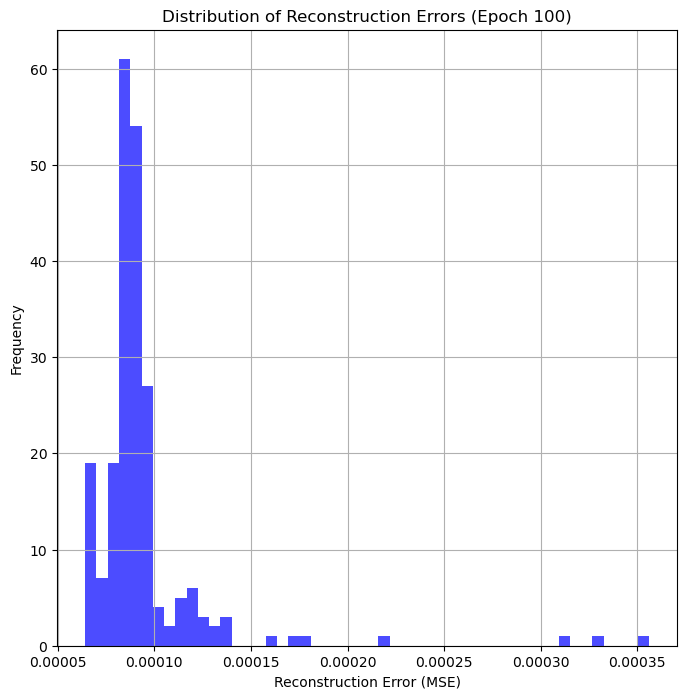

In [53]:
# Will use the images in the "train/good" directory to establish a baseline of features for defect-free images.
item = "capsule"

# Iterate through the directories of images
item_path = os.path.join(base_dir, item)
train_path = os.path.join(item_path, 'train')
test_path = os.path.join(item_path, 'test')

print(f"Processing: {item}")
# Create the dataset and DataLoader    
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

model = Autoencoder()
# Initialize loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6, verbose=True)
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_performing_model, reconstruction_errors = train_autoencoder(model, train_loader, item, epochs, device, optimizer, scheduler)    

In [58]:
thresholds = [0.0001, 0.000075, 0.00005]
test_dataset = TestDataset(root_dir=test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

for threshold in thresholds:
    print(f"Testing with threshold: {threshold}")
    test_autoencoder(model, best_performing_model, test_loader, device, threshold)
    print("-" * 50)

Testing with threshold: 0.0001
Loaded best model weights from training.
Test Accuracy: 0.2803
False Positive Rate: 0.1739
Precision: 0.8182
Recall: 0.1651
F1 Score: 0.2748
--------------------------------------------------
Testing with threshold: 7.5e-05
Loaded best model weights from training.
Test Accuracy: 0.7576
False Positive Rate: 0.8261
Precision: 0.8348
Recall: 0.8807
F1 Score: 0.8571
--------------------------------------------------
Testing with threshold: 5e-05
Loaded best model weights from training.
Test Accuracy: 0.8258
False Positive Rate: 1.0000
Precision: 0.8258
Recall: 1.0000
F1 Score: 0.9046
--------------------------------------------------
